## Objective
Evaluate model's performance when a sliding window of an entire recording

In [1]:
%load_ext autoreload
# %autoreload

# Update PATH to allow imports
import sys
if "/data/MEAprojects/DLSpikeSorter" not in sys.path:
    sys.path.append("/data/MEAprojects/DLSpikeSorter")

# Imports
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
import torch
from pathlib import Path
from src.model import ModelSpikeSorter
from src.plot import set_ticks
from src.utils import random_seed
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

#### Setup for running model

In [2]:
# # Params for getting windows in recording
# REC = "2950"
# WINDOW_SIZE = 200
# STRIDE = 120
# WINDOW_SAVE_PATH = f"/data/MEAprojects/DLSpikeSorter/{REC}/windows_{WINDOW_SIZE}_{STRIDE}.npy" # Path to save np.array of windows (n_windows, 1, window_size)
# REC_PATH = f"/data/MEAprojects/DLSpikeSorter/{REC}/data.raw.npy"
# ##
# rec = np.load(REC_PATH, mmap_mode="r")
# num_channels, num_samples = rec.shape
# num_windows = int(num_channels * ((num_samples - WINDOW_SIZE) / STRIDE + 1))
#
# print(f"Num windows: {num_windows}")
# print(f"Expected model run-time: {num_windows * 15/2000 * 1/1000/60} min")  # Doesn't include time to format data
# Params for getting windows in recording
WINDOW_SIZE = 200
STRIDE = 120
WINDOW_SAVE_PATH = f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/windows_{WINDOW_SIZE}_{STRIDE}.npy" # Path to save np.array of windows (n_windows, 1, window_size)
REC_PATH = f"/data/MEAprojects/dandi/000034/sub-mouse412804/sub-mouse412804_ecephys.npy"
##
rec = np.load(REC_PATH, mmap_mode="r")
num_channels, num_samples = rec.shape
num_windows = int(num_channels * ((num_samples - WINDOW_SIZE) / STRIDE + 1))

print(f"Change num_windows to int((num_samples - WINDOW_SIZE) / STRIDE + 1) * num_channels")

print(f"Num windows: {num_windows}")
print(f"Expected model run-time: {num_windows * 15/2000 * 1/1000/60} min")  # Doesn't include time to format data

Num windows: 55799834
Expected model run-time: 6.9749792500000005 min


In [11]:
# Save windows in recording --> Don't run if windows have already been saved!
class GetWindowsWrapper:
    """
    Wrapper class for func in multiprocessing for getting windows of recording
    """

    def __init__(self, rec_path, window_size, stride):
        self.rec_path = rec_path
        self.window_size = window_size
        self.stride = stride

    def __call__(self, i):
        rec = np.load(self.rec_path, mmap_mode="r")
        start_frame = i*self.stride
        return rec[:, start_frame:start_frame+self.window_size]

windows_all = np.zeros((num_windows, 1, WINDOW_SIZE), dtype="float32")

print("Extracting windows ...")
with Pool(processes=24) as pool:
    tasks = range(0, int(num_windows / num_channels))
    windows_wrapper = GetWindowsWrapper(REC_PATH, WINDOW_SIZE, STRIDE)
    for i, windows in tqdm(enumerate(pool.imap(windows_wrapper, tasks, chunksize=100)), total=len(tasks)):
        start_window_idx = i * num_channels
        windows_all[start_window_idx:start_window_idx + num_channels, 0, :] = windows
np.save(WINDOW_SAVE_PATH, windows_all)

Extracting windows ...


100%|██████████| 224999/224999 [01:19<00:00, 2825.22it/s] 


In [5]:
# Load windows
windows_all = np.load(WINDOW_SAVE_PATH, mmap_mode="r")

In [6]:
# Load model
MODEL_PATH = "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5118/230101_135307_305876"
model = ModelSpikeSorter.load(MODEL_PATH).eval().cuda()

In [7]:
# Params for saving model's results on recording
# MODEL_OUTPUTS_PATH = Path(MODEL_PATH) / "log" / f"windows_{WINDOW_SIZE}_{STRIDE}_outputs.npy"
MODEL_OUTPUTS_PATH = f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/windows_{WINDOW_SIZE}_{STRIDE}_outputs.npy"
# MODEL_SPIKE_TIMES_PATH = Path(MODEL_PATH) / "log" / f"windows_{WINDOW_SIZE}_{STRIDE}_spike_times.npy"
MODEL_SPIKE_TIMES_PATH = f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/windows_{WINDOW_SIZE}_{STRIDE}_spike_times.npy"
BATCH_SIZE = 50000

#### Test model on a few windows before whole recording

Using random seed 12


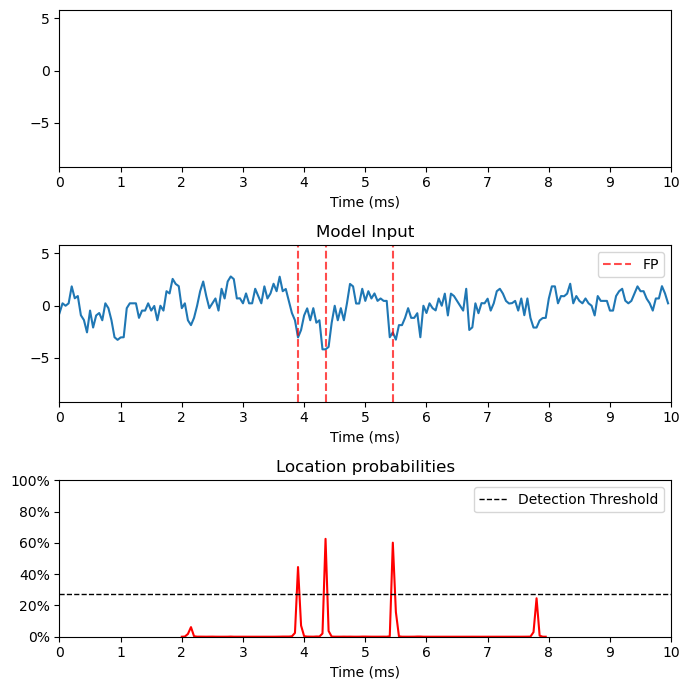

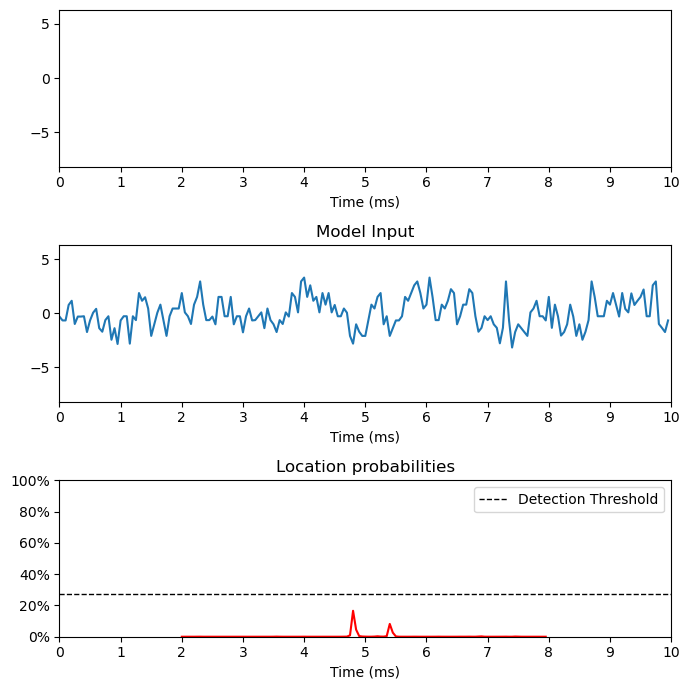

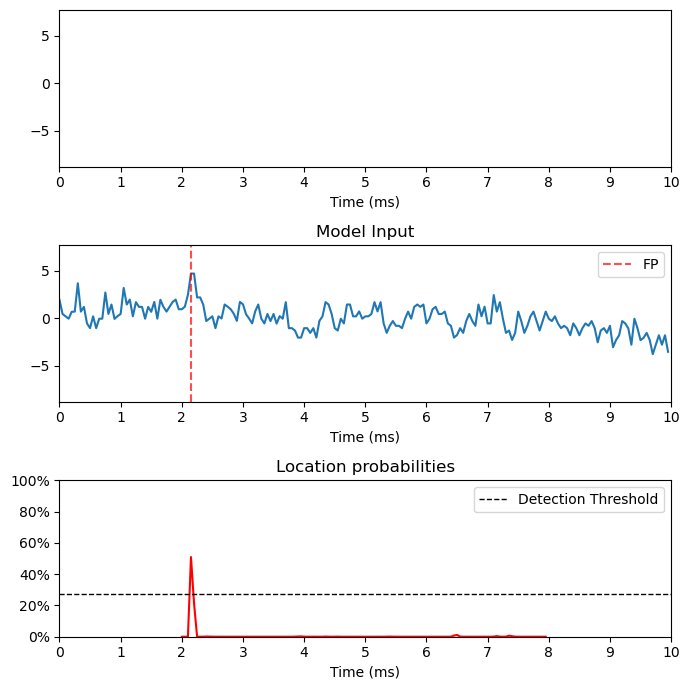

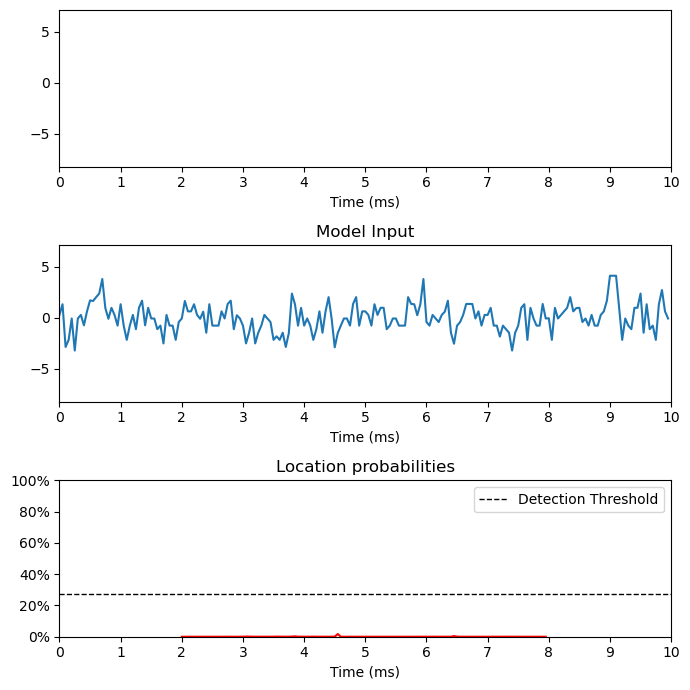

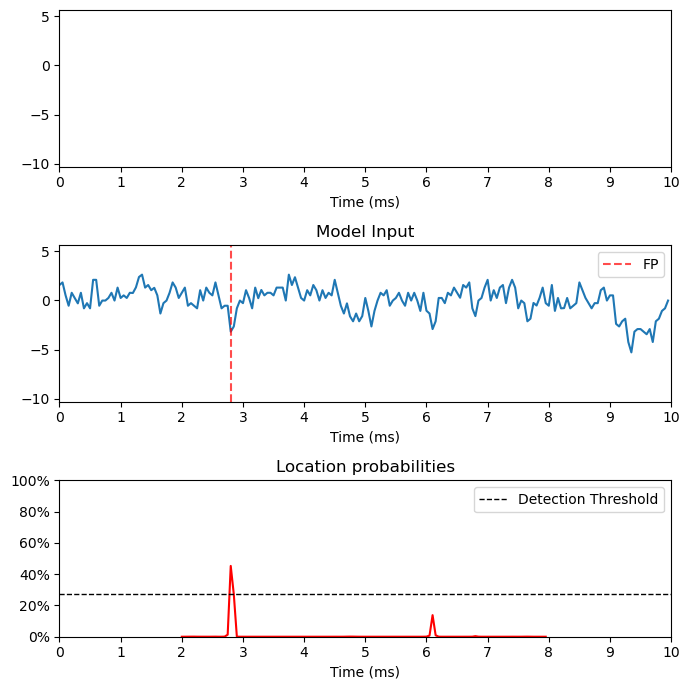

In [7]:
from src import utils
utils.random_seed(12)

windows_ind = np.random.choice(len(windows_all), 5)
windows = windows_all[windows_ind, :, :]
windows = windows - np.mean(windows, axis=2, keepdims=True)
windows = windows / np.std(windows, axis=2, keepdims=True) * 1.38

inputs = torch.tensor(windows, device="cuda")
with torch.no_grad():
    outputs = model(inputs).cpu()
preds = model.outputs_to_preds(outputs)
for trace, output, pred in zip(inputs, outputs, preds):
    model.plot_pred(trace, output, pred, 0, [], [], None)

In [8]:
# Get model's outputs and spike times from windows --> Don't run if model's outputs have already been saved!
print("Allocating memory for model outputs ...")
outputs_all = np.zeros((len(windows_all), 120), dtype="float32")
np.save(MODEL_OUTPUTS_PATH, outputs_all)
outputs_all = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r+")

spike_times = [[] for _ in range(num_channels)]

# outputs_all = np.memmap(MODEL_OUTPUTS_PATH, dtype="float32", mode="w+", shape=(len(windows_all), 120))
# spike_times = np.memmap(MODEL_SPIKE_TIMES_PATH, dtype=list, mode="w+", shape=(num_channels,))

print("Running model ...")
for i in tqdm(range(0, len(windows_all), BATCH_SIZE)):
    inputs = windows_all[i:i+BATCH_SIZE, :, :]
    inputs = inputs - np.mean(inputs, axis=2, keepdims=True)
    inputs = inputs / np.std(inputs, axis=2, keepdims=True) * 1.38
    inputs = torch.tensor(inputs, device="cuda")

    with torch.no_grad():
        outputs = model(inputs).cpu().numpy()
    for j, pred in enumerate(model.outputs_to_preds(outputs)):
        idx = i + j
        channel = idx % num_channels
        spike_offset = (idx // num_channels) * STRIDE  # Add this to spike idx of window to get spike idx in recording
        for spike in pred:
            spike_times[channel].append(spike + spike_offset)
    outputs_all[i:i+len(outputs), :] = outputs

Running model ...


100%|█████████▉| 1115/1116 [22:40<00:01,  1.13s/it]/tmp/ipykernel_2591018/2998936381.py:16: RuntimeWarning: invalid value encountered in divide
  inputs = inputs / np.std(inputs, axis=2, keepdims=True) * 1.38
100%|██████████| 1116/1116 [22:41<00:00,  1.22s/it]


In [9]:
spike_times = [np.array(st) for st in spike_times]
np.save(MODEL_SPIKE_TIMES_PATH, spike_times)

/home/mea/anaconda3/envs/dl_env/lib/python3.8/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
# For "RuntimeWarning: invalid value encountered in divide inputs = inputs / np.std(inputs, axis=2, keepdims=True) * 1.38"
# test = windows_all[55750000:55750000+BATCH_SIZE, 0, :]
# stds = np.std(test, axis=1, keepdims=True)
# zeros = stds == 0
# for i in np.flatnonzero(zeros):
#     print(np.all(test[i, :] == 0))
#     plt.plot(test[i, :])
#     plt.plot(outputs_all[i, :])
#     plt.show()

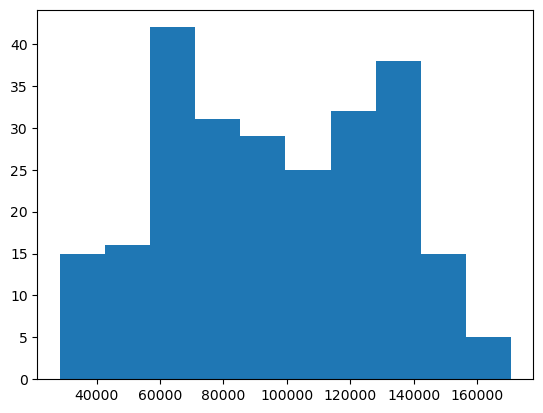

In [10]:
test = [len(st) for st in spike_times]
plt.hist(test)
plt.show()

In [15]:
def count_matching_events(times1, times2, delta=8):
    """
    From spikeinterface

    Counts matching events.

    Parameters
    ----------
    times1: list
        List of spike train 1 (in samples)
    times2: list
        List of spike train 2 (in samples)
    delta: int
        Max difference for considering matching events (in samples)

    Returns
    -------
    matching_count: int
        Number of matching events
    """
    times_concat = np.concatenate((times1, times2))
    membership = np.concatenate((np.ones(len(times1)) * 1, np.ones(len(times2)) * 2))
    indices = times_concat.argsort()
    times_concat_sorted = times_concat[indices]
    membership_sorted = membership[indices]
    diffs = times_concat_sorted[1:] - times_concat_sorted[:-1]
    inds = np.where((diffs <= delta) & (membership_sorted[:-1] != membership_sorted[1:]))[0]
    if len(inds) == 0:
        return 0
    inds2 = np.where(inds[:-1] + 1 != inds[1:])[0]  # Prevents a spike being matched with more than one other spike
    return len(inds2) + 1


def compare_sortings(sorter1: tuple, sorter2: tuple):
    """
    Compare number of spikes detected
    standard spike_times format = list where ith element is a list of spikes detected on ith channel in raw recording

    :param sorter1:
        0) str: name of sorter
        1) list: spike times in standard format
    :param sorter2:
        0) str: name of sorter
        1) list: spike times in standard format
    """

    spike_times1 = sorter1
    spike_times2 = sorter2
    # name1, spike_times1 = sorter1
    # name2, spike_times2 = sorter2

    assert len(spike_times1) == len(spike_times2), "Number of channels in 'sorter1' must equal number of channels in 'sorter2'"

    num_sorter1 = 0
    num_sorter2 = 0
    num_matching = 0
    for st1, st2 in zip(spike_times1, spike_times2):
        num_sorter1 += len(st1)
        num_sorter2 += len(st2)
        num_matching += count_matching_events(st1, st2)

    # print(f"Spike counts over all {len(spike_times1)} channels:")
    # print(f"{name1}: {num_sorter1}")
    # print(f"{name2}: {num_sorter2}")
    # print(f"Matching: {num_matching}")
    # print(f"Matching/{name1}: {num_matching/num_sorter1*100:.1f}%")
    # print(f"Matching/{name2}: {num_matching/num_sorter2*100:.1f}%")

    return num_sorter1, num_sorter2, num_matching, num_matching/num_sorter1*100, num_matching/num_sorter2*100


# %autoreload 2
from src.analysis.standardize import get_kilosort_spike_times, count_spikes

In [8]:
# Find how many of model's and kilosort's spike times overlap
# compare_sortings(("Model", spike_times_model), ("Kilosort", spike_times_ks))

In [16]:
#
THRESH_AMP = 30
THRESH_STD = None
THRESH_RMS = None
MAX_CHAN_ONLY = False
COLUMNS = ["Num Model's Spikes", "Num Kilosort's Spikes", "Num Matches", "Num Matches/Num Model's Spikes (%)", "Num Matches/Num Kilosort's Spikes (%)"]
pd.options.display.float_format = '{:.1f}'.format
##
# Load kilosort's spike times for comparison
print(f"Amp Thresh: {THRESH_AMP}, STD Thresh: {THRESH_STD}, Amp/RMS Thresh: {THRESH_RMS}")
# from pandas import DataFrame
rec_to_model = {
    # "2950": "230101_133131_959516",
    # "2953": "230101_133514_582221",
    # "2954": "230101_134042_729459",
    # "2957": "230101_134408_403069",
    # "5116": "230101_134927_487762",
    "5118": "230101_135307_305876",
}

for CURATION in ("initial", "first", "second"):
    data = []
    for rec, model_name in rec_to_model.items():
        model_spike_times_path = f"/data/MEAprojects/DLSpikeSorter/models/v0_4_4/{rec}/{model_name}/log/windows_200_120_spike_times.npy"
        spike_times_model = np.load(model_spike_times_path, allow_pickle=True)

        spike_times_ks = get_kilosort_spike_times(rec, CURATION,
                                                  max_chan_only=MAX_CHAN_ONLY,
                                                  thresh_amp=THRESH_AMP, thresh_std=THRESH_STD, thresh_rms=THRESH_RMS)
        if count_spikes(spike_times_ks) == 0:
            # num_sorter1, num_sorter2, num_matching, num_matching/num_sorter1*100, num_matching/num_sorter2*100
            data.append((count_spikes(spike_times_model), 0, 0, 0, np.nan))
        else:
            data.append(compare_sortings(spike_times_model, spike_times_ks))
    data_np = np.vstack(data)
    mean = np.nanmean(data_np, axis=0)
    std = np.nanstd(data_np, axis=0)
    data.append(mean)
    data.append(std)

    display(pd.DataFrame(data, columns=COLUMNS, index=list(rec_to_model.keys()) + ["Mean", "STD"]))

    # print("\n"+CURATION)
    # print("Recording,Num Model's Spikes,Num Kilosort's Spikes,Num Matches,Num Matches/Num Model's Spikes (%),Num Matches/Num Kilosort's Spikes (%)")
    # for d, rec in zip(data, list(rec_to_model.keys()) + ["Mean", "STD"]):
    #     print(rec + ", " + ", ".join([f"{x:.1f}" for x in d]))


Amp Thresh: 30, STD Thresh: None, Amp/RMS Thresh: None


,Num Model's Spikes,Num Kilosort's Spikes,Num Matches,Num Matches/Num Model's Spikes (%),Num Matches/Num Kilosort's Spikes (%)
2950,872024.0,6683.0,6413.0,0.7,96.0
2953,1641130.0,56091.0,43201.0,2.6,77.0
2954,1104608.0,8443.0,8086.0,0.7,95.8
2957,3019315.0,10122.0,9157.0,0.3,90.5
5116,1785967.0,25862.0,17376.0,1.0,67.2
5118,3278126.0,1649.0,1632.0,0.0,99.0
Mean,1950195.0,18141.7,14310.8,0.9,87.6
STD,904284.3,18535.7,13738.5,0.8,11.6


,Num Model's Spikes,Num Kilosort's Spikes,Num Matches,Num Matches/Num Model's Spikes (%),Num Matches/Num Kilosort's Spikes (%)
2950,872024.0,6575.0,6321.0,0.7,96.1
2953,1641130.0,37591.0,33828.0,2.1,90.0
2954,1104608.0,8226.0,7892.0,0.7,95.9
2957,3019315.0,9877.0,8914.0,0.3,90.3
5116,1785967.0,7959.0,6870.0,0.4,86.3
5118,3278126.0,1649.0,1632.0,0.0,99.0
Mean,1950195.0,11979.5,10909.5,0.7,92.9
STD,904284.3,11737.1,10502.3,0.7,4.4


,Num Model's Spikes,Num Kilosort's Spikes,Num Matches,Num Matches/Num Model's Spikes (%),Num Matches/Num Kilosort's Spikes (%)
2950,872024.0,6304.0,6076.0,0.7,96.4
2953,1641130.0,33400.0,30893.0,1.9,92.5
2954,1104608.0,7825.0,7503.0,0.7,95.9
2957,3019315.0,9835.0,8872.0,0.3,90.2
5116,1785967.0,6851.0,6036.0,0.3,88.1
5118,3278126.0,1649.0,1632.0,0.0,99.0
Mean,1950195.0,10977.3,10168.7,0.7,93.7
STD,904284.3,10327.2,9530.6,0.6,3.8


Using random seed 5123
this is invalid, need to respecify model and corresponding recording and kilosort data


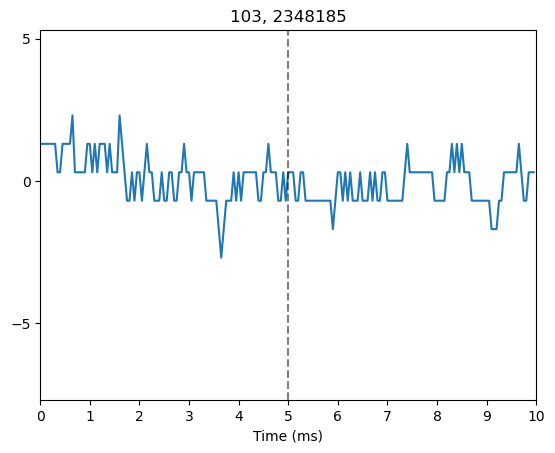

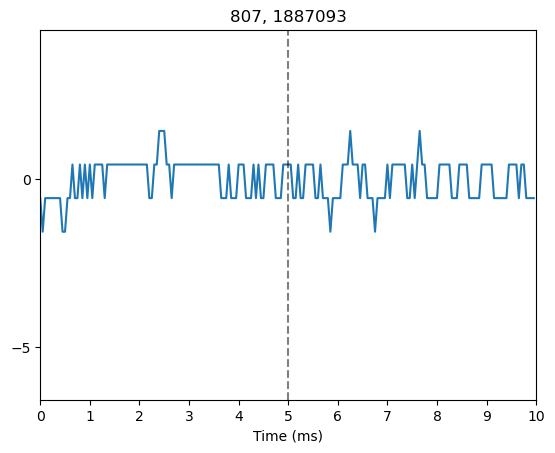

In [64]:
# Plot spikes detected by model but not by kilosort
NUM_PLOTS = 2
random_seed(5123)
print("this is invalid, need to respecify model and corresponding recording and kilosort data")
##

count = 0
while count < NUM_PLOTS:
    # Get random spike
    chan = np.random.choice(len(spike_times_model))
    spike_times = spike_times_model[chan]
    if len(spike_times) == 0: continue
    st = np.random.choice(spike_times)

    # Skip this spike if it was also detected by kilosort
    cont = False
    for buffer in range(-8, 9, 1):
        if st + buffer in spike_times_ks[chan]:
            cont = True
            break
    if cont: continue

    # Extract window surrounding spike
    window = rec[chan, st-WINDOW_SIZE//2:st+WINDOW_SIZE//2]
    window = window - np.mean(window)

    # Plot window
    fig, a0 = plt.subplots(1)
    set_ticks((a0,), window)
    a0.set_title(f"{chan}, {st}")
    a0.plot(window)
    a0.axvline(WINDOW_SIZE//2, color="black", linestyle="dashed", alpha=0.5)
    plt.show()

    count += 1

In [1]:
print('hello world!')

hello world!
